In [7]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [16]:
import pathlib

train_dir = pathlib.Path("./train/")

test_dir = pathlib.Path("./test/")

In [17]:
image_count = len(list(train_dir.glob('*/*.jpg')))
print(image_count)

1156


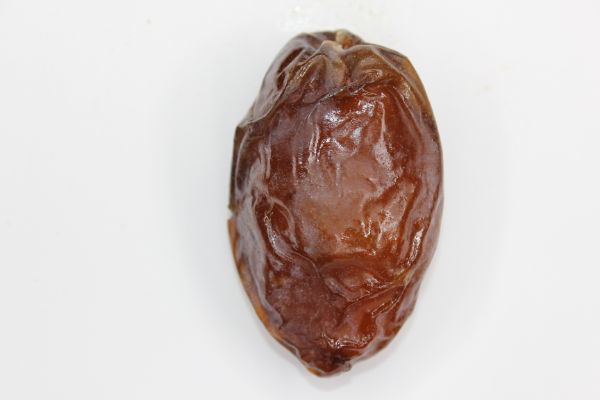

In [18]:
medjool = list(train_dir.glob('Medjool/*'))
PIL.Image.open(str(medjool[0]))

In [20]:
batch_size = 32
img_height = 180
img_width = 180

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Using 925 files for training.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 1156 files belonging to 9 classes.
Using 231 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']


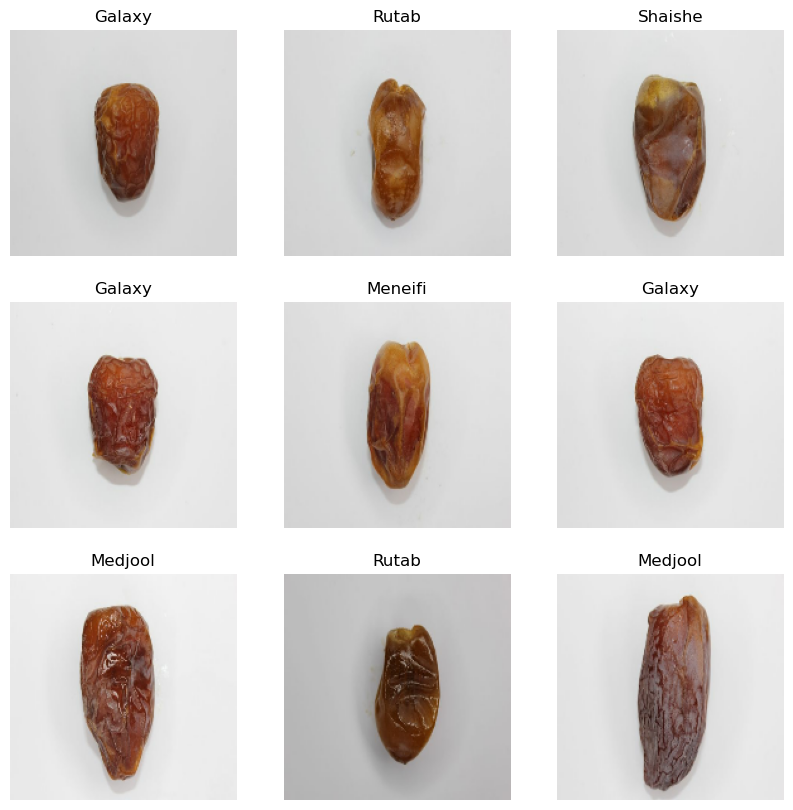

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [25]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./255)

In [28]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.016557522 1.0


In [29]:
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [32]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 19s 558ms/step - loss: 2.3442 - accuracy: 0.2032 - val_loss: 1.9307 - val_accuracy: 0.3074
Epoch 2/10
29/29 [==============================] - 15s 525ms/step - loss: 1.4945 - accuracy: 0.4605 - val_loss: 1.0700 - val_accuracy: 0.5714
Epoch 3/10
29/29 [==============================] - 15s 522ms/step - loss: 0.9204 - accuracy: 0.6757 - val_loss: 0.7857 - val_accuracy: 0.7013
Epoch 4/10
29/29 [==============================] - 15s 524ms/step - loss: 0.6022 - accuracy: 0.8022 - val_loss: 0.6461 - val_accuracy: 0.7835
Epoch 5/10
29/29 [==============================] - 16s 554ms/step - loss: 0.4358 - accuracy: 0.8562 - val_loss: 0.8312 - val_accuracy: 0.7013
Epoch 6/10
29/29 [==============================] - 19s 674ms/step - loss: 0.4539 - accuracy: 0.8476 - val_loss: 0.5392 - val_accuracy: 0.8268
Epoch 7/10
29/29 [==============================] - 16s 553ms/step - loss: 0.3461 - accuracy: 0.8919 - val_loss: 0.4579 - val_accuracy: 0.8442

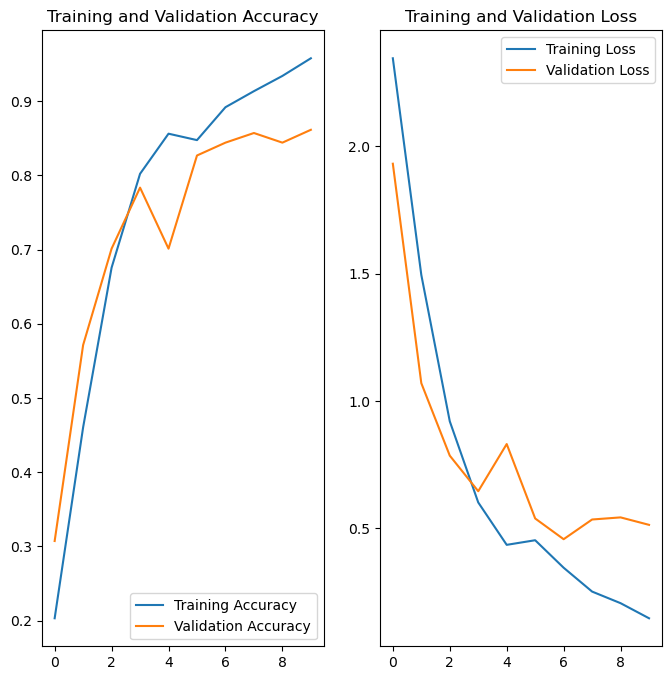

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
        input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

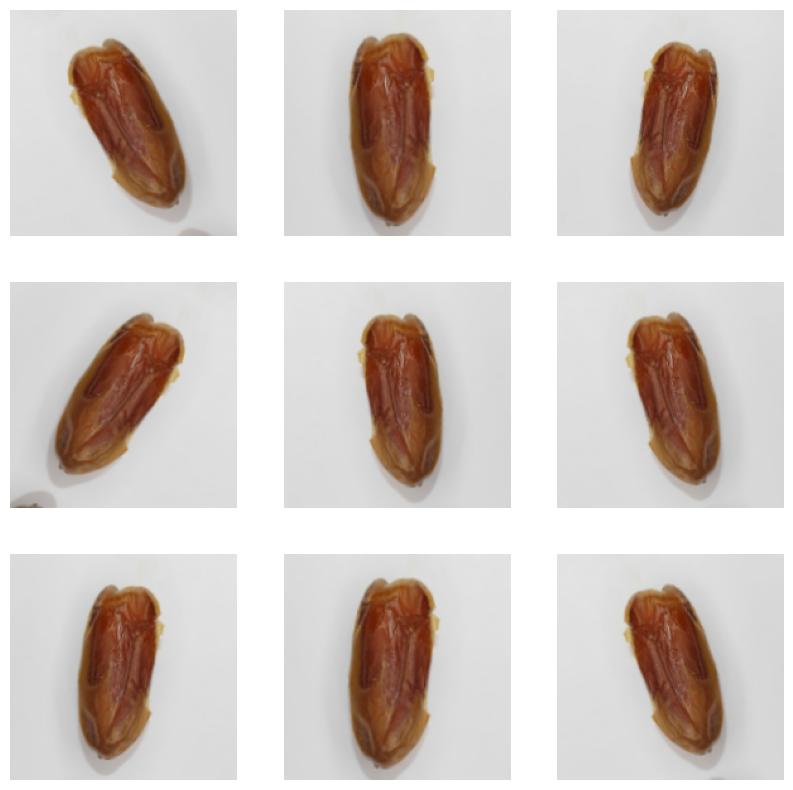

In [35]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [36]:
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [37]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [39]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
29/29 [==============================] - 29s 677ms/step - loss: 2.2079 - accuracy: 0.1827 - val_loss: 1.9704 - val_accuracy: 0.3896
Epoch 2/15
29/29 [==============================] - 19s 659ms/step - loss: 1.6152 - accuracy: 0.3946 - val_loss: 1.5072 - val_accuracy: 0.3983
Epoch 3/15
29/29 [==============================] - 19s 655ms/step - loss: 1.1577 - accuracy: 0.5935 - val_loss: 0.9408 - val_accuracy: 0.6926
Epoch 4/15
29/29 [==============================] - 19s 644ms/step - loss: 0.8563 - accuracy: 0.7049 - val_loss: 0.9940 - val_accuracy: 0.6537
Epoch 5/15
29/29 [==============================] - 19s 644ms/step - loss: 0.7333 - accuracy: 0.7319 - val_loss: 0.6554 - val_accuracy: 0.7879
Epoch 6/15
29/29 [==============================] - 19s 670ms/step - loss: 0.6397 - accuracy: 0.7827 - val_loss: 0.6159 - val_accuracy: 0.8052
Epoch 7/15
29/29 [==============================] - 20s 681ms/step - loss: 0.5517 - accuracy: 0.8086 - val_loss: 0.5226 - val_accuracy: 0.8528

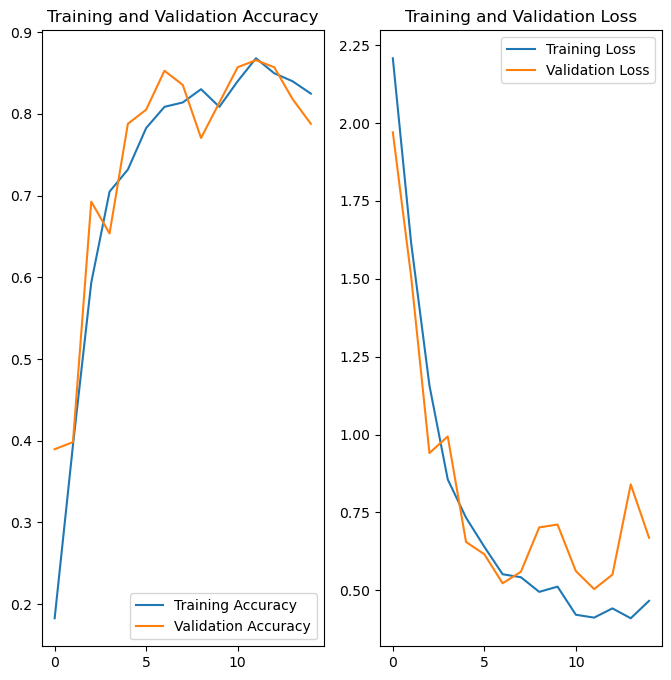

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [42]:
img = tf.keras.utils.image_dataset_from_directory(
test_dir
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Found 502 files belonging to 9 classes.


TypeError: float() argument must be a string or a real number, not 'BatchDataset'

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [ ]:
interpreter.get_signature_list()

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))